### Mapping Network Topology with Netflow Data in CAS (IN-PROGRESS)

This notebook demonstrates how to generate network graphs of the network as defined in netflow data.

Inspired by the blog post: [Analyzing social networks using Python and SAS Viya](https://blogs.sas.com/content/sascom/2016/10/20/analyzing-social-networks-using-python-sas-viya/) by Falko Schulz. This notebook applies some of the principles and examples in this post, but with netflow data to bring into a cybersecurity context.


__Damian Herrick__  
__SAS Institute__  
__[damian.herrick@sas.com](mailto:damian.herrick@sas.com)__  

In [1]:
import os
import numpy as np
import pandas as pd
import swat
from swat.cas import datamsghandlers as dmh

import matplotlib.pyplot as plt
import matplotlib.colors as colors # package includes utilities for color ranges
import matplotlib.cm as cmx
import networkx as nx

%matplotlib inline

Let's make a helper function to draw a network graph.

In [3]:
os.environ["CAS_CLIENT_SSL_CA_LIST"]="/home/ds/cascert.pem"

conn = swat.CAS("d-crd-datasci01big.dev.cyber.sas.com", 5570)

In [4]:
conn.dropcaslib(caslib='LANL_NF', quiet=True)

conn.addcaslib(name='LANL_NF', path='/home/datasets/LANL/NF/', 
               description="LANL Netflow",
               session=False)
conn.setsessopt(caslib='LANL_NF')

NOTE: Cloud Analytic Services removed the caslib 'LANL_NF'.
NOTE: 'LANL_NF' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'LANL_NF'.
NOTE: 'LANL_NF' is now the active caslib.


+ Elapsed: 0.000859s, user: 0.000288s, sys: 0.0005s, mem: 0.225mb

In [5]:
conn.loadtable("nf_day_02_hr13.sashdat", caslib="LANL_NF")

NOTE: Cloud Analytic Services made the file nf_day_02_hr13.sashdat available as table NF_DAY_02_HR13 in caslib LANL_NF.


[caslib]

 'LANL_NF'

[tableName]

 'NF_DAY_02_HR13'

[casTable]

 CASTable('NF_DAY_02_HR13', caslib='LANL_NF')

+ Elapsed: 0.00644s, user: 0.00274s, sys: 0.00356s, mem: 0.935mb

In [6]:
pairsCode = F'''CREATE TABLE nf_day_02_hr13_pairs AS SELECT SrcDevice, DstDevice, COUNT(*) FROM nf_day_02_hr13 GROUP BY SrcDevice, DstDevice '''
print(pairsCode)

CREATE TABLE nf_day_02_hr13_pairs AS SELECT SrcDevice, DstDevice, COUNT(*) FROM nf_day_02_hr13 GROUP BY SrcDevice, DstDevice 


In [7]:
conn.loadactionset("fedsql")

NOTE: Added action set 'fedsql'.


[actionset]

 'fedsql'

+ Elapsed: 0.00343s, user: 0.00313s, sys: 0.000238s, mem: 0.23mb

In [8]:
conn.fedsql.execdirect(pairsCode)

NOTE: Table NF_DAY_02_HR13_PAIRS was created in caslib LANL_NF with 100063 rows returned.


+ Elapsed: 2.55s, user: 3.22s, sys: 3.02s, mem: 458mb

In [9]:
conn.save(table='nf_day_02_hr13_pairs', name='nf_day_02_hr13_pairs.sashdat', caslib='LANL_NF', replace=True)

NOTE: Cloud Analytic Services saved the file nf_day_02_hr13_pairs.sashdat in caslib LANL_NF.


[caslib]

 'LANL_NF'

[name]

 'nf_day_02_hr13_pairs.sashdat'

+ Elapsed: 0.0275s, user: 0.00144s, sys: 0.0228s, mem: 16.5mb

In [10]:
conn.loadactionset('hypergroup')

NOTE: Added action set 'hypergroup'.


[actionset]

 'hypergroup'

+ Elapsed: 0.00176s, user: 0.00111s, sys: 0.0006s, mem: 0.223mb

In [ ]:
conn.hyperGroup.hyperGroup(
    createOut         = "NEVER", # this suppresses the creation of a table that’s usually produced, but it’s not needed here
    allGraphs         = True, # process all graphs even if disconnected
    community         = True,
    nCommunities      = 4,
    centrality        = True,
    scaleCentralities = "CENTRAL1",
    inputs            = ["SrcDevice", "DstDevice"], # the source and target column indicating an edge
    table             = 'nf_day_02_hr13_pairs', # the input data set
    edges             = {'name':'edges','replace':True}, # result table containing edge attributes
    vertices          = {'name':'nodes','replace':True}  # result table containing vertice attributes
)

In [ ]:
conn.save(table='nodes', name='nodes.sashdat', caslib='LANL_NF', replace=True)
conn.save(table='edges', name='edges.sashdat', caslib='LANL_NF', replace=True)

In [11]:
conn.loadtable('nodes.sashdat', caslib='LANL_NF')
conn.loadtable('edges.sashdat', caslib='LANL_NF')

NOTE: Cloud Analytic Services made the file nodes.sashdat available as table NODES in caslib LANL_NF.
NOTE: Cloud Analytic Services made the file edges.sashdat available as table EDGES in caslib LANL_NF.


[caslib]

 'LANL_NF'

[tableName]

 'EDGES'

[casTable]

 CASTable('EDGES', caslib='LANL_NF')

+ Elapsed: 0.00177s, user: 0.00136s, sys: 0.000238s, mem: 0.666mb

In [12]:
nodesOut = conn.CASTable('nodes')
nodesOut.distinct()

,Column,NDistinct,NMiss,Trunc
0,_HypGrp_,13.0,0.0,0.0
1,_Value_,19537.0,0.0,0.0
2,_Index_,19537.0,0.0,0.0
3,_IndexH_,19500.0,0.0,0.0
4,_AllXCoord_,19537.0,0.0,0.0
5,_AllYCoord_,19537.0,0.0,0.0
6,_XCoord_,19515.0,0.0,0.0
7,_YCoord_,19515.0,0.0,0.0
8,_Color_,43.0,0.0,0.0
9,_Community_,4.0,0.0,0.0


In [13]:
conn.simple.topK(
    aggregator = "N",
    topK       = 4,
    table      = 'nodes',
    inputs     = ["_Community_"],
    casOut     = {'name':'topKOut','replace':True}
)

topKOut = conn.fetch(sortBy=["_Rank_"],to=10, table={'name':'topKOut'})

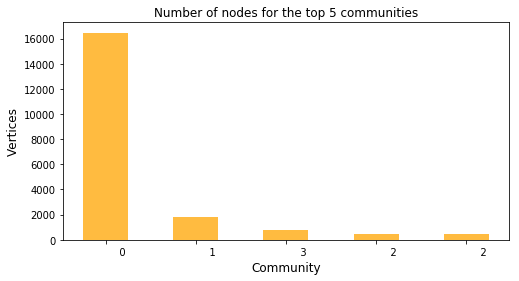

In [14]:
topKOutFetch = topKOut['Fetch']
ind = np.arange(5)    # the x locations for the bars
plt.figure(figsize=(8,4))
p1 = plt.bar(ind + 0.2, topKOutFetch._Score_, 0.5, color='orange', alpha=0.75)

plt.ylabel('Vertices', fontsize=12)
plt.xlabel('Community', fontsize=12)
plt.title('Number of nodes for the top 5 communities')
plt.xticks(ind + 0.2, topKOutFetch._Fmtvar_)
plt.show()

In [15]:
nodesOut = conn.CASTable('nodes', where="_Community_ EQ 1")
nodesOut.fetch(to=5, sastypes=False, format=True)

,_HypGrp_,_Value_,_Index_2,_IndexH_,_AllXCoord_,_AllYCoord_,_XCoord_,_YCoord_,_Color_,_Community_,_AllCommunity_,_Reach_,_Stress_,_Closeness_,_Betweenness_,_CentroidMag_,_CentroidAngle_
0,0,Comp000156,2,3667,51.717630758,47.275226832,73.220632086,42.939238312,37,1,1,7,0,0.4601663468,0,0.1359444125,105.08337192
1,0,Comp045395,751,3666,52.38687787,47.527483334,74.057721824,43.772578517,37,1,1,7,0,0.4601663468,0,0.1220121265,103.5212848
2,0,Comp062786,1026,3665,47.375643647,59.144960111,58.203202679,46.680936943,37,1,1,7,0.0021737253,0.4959564939,0.0058007013,0.4924120852,105.87311514
3,0,Comp092552,1519,3664,52.148657038,47.899405108,74.826694467,41.931841743,37,1,1,7,0,0.4601663468,0,0.0940817292,105.90367513
4,0,Comp106398,1754,3663,51.106415475,47.441569561,74.313184189,43.749078982,37,1,1,7,0,0.4601663468,0,0.1161631622,103.46498258


In [ ]:
conn.close()